<a href="https://colab.research.google.com/github/ClearVis-Bangkit/MachineLearning-ClearVis/blob/main/Retinoblastoma_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np

## Upload datasetnya dari drive yang folder dataset_zip

In [2]:
#! rm -r /content/Retinoblastoma_Dataset\ copy
! unzip /content/small_retinoblastoma_dataset.zip
#! unzip /content/sample_data/RetinoblastomaDataset

Archive:  /content/small_retinoblastoma_dataset.zip
   creating: Small Retinoblastoma Dataset/training/
   creating: Small Retinoblastoma Dataset/training/normal/
  inflating: Small Retinoblastoma Dataset/training/normal/1 copy.jpg  
  inflating: Small Retinoblastoma Dataset/training/normal/1000_F_169877142_xW0SNK7idjGbFTFoMbmldworYcp6YW8M.jpeg  
  inflating: Small Retinoblastoma Dataset/training/normal/123047523-close-up-of-a-surprised-emotional-man-with-brown-eyes.jpeg  
  inflating: Small Retinoblastoma Dataset/training/normal/1579590672_8-p-detskie-glaza-10.jpeg  
  inflating: Small Retinoblastoma Dataset/training/normal/1579590711_7-p-detskie-glaza-9.jpeg  
  inflating: Small Retinoblastoma Dataset/training/normal/1579590741_33-p-detskie-glaza-60.jpeg  
  inflating: Small Retinoblastoma Dataset/training/normal/1622003991_48104_url.jpeg  
  inflating: Small Retinoblastoma Dataset/training/normal/1640283-photo-getty-images-bananastock-rf-kids-eyes-png-632_422_preview.png  
  inflati

In [3]:
# base_dir = '/content/Retinoblastoma_Dataset_2class' # Membuat folder food class
base_dir = '/content/Small Retinoblastoma Dataset'
train_dir = os.path.join(base_dir, 'training') # Membuat sebuah direktori 'training' pada variabel train_dir
validation_dir = os.path.join(base_dir, 'validation') # Membuat sebuah direktori 'validation' pada variabel validation_dir

## Image augmentation

In [4]:
# Membuat direktori training setiap kelas pada masing-masing variabel training
# train_normal_eyes_dir = os.path.join(train_dir, 'normal_eyes')
# train_retinoblastoma_dir = os.path.join(train_dir, 'Retinoblastoma')
#train_squint_dir = os.path.join(train_dir, 'squint')
train_normal_eyes_dir = os.path.join(train_dir, 'normal')
train_retinoblastoma_dir = os.path.join(train_dir, 'retinoblastoma')

# Membuat direktori validation setiap kelas pada masing-masing variabel validation
# validation_normal_eyes_dir = os.path.join(validation_dir, 'normal_eyes')
# validation_retinoblastoma_dir  = os.path.join(validation_dir, 'Retinoblastoma')
validation_normal_eyes_dir = os.path.join(validation_dir, 'normal')
validation_retinoblastoma_dir  = os.path.join(validation_dir, 'retinoblastoma')

# menghitung jumlah direktori train dan validation
train_normal_eyes = len(os.listdir(train_normal_eyes_dir))
train_retinoblastoma = len(os.listdir(train_retinoblastoma_dir))
validation_normal_eyes = len(os.listdir(validation_normal_eyes_dir))
validation_retinoblastoma = len(os.listdir(validation_retinoblastoma_dir))


print(train_normal_eyes + train_retinoblastoma, ' Size of Trains')
print(validation_normal_eyes + validation_retinoblastoma, ' Size of Validations')

204  Size of Trains
40  Size of Validations


In [5]:
# Pre-processing data dengan image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [23]:
def data_augment(train_datagen, test_datagen, class_mode='categorical'):
  train_generator = train_datagen.flow_from_directory(
          train_dir,  # Direktori data latih
          target_size=(224, 224),  # Mengubah resolusi seluruh gambar menjadi 224x224 piksel
          batch_size=24,
          class_mode= class_mode # Menggunakan class_mode = 'binary' Karena klasifikasi 2 kelas
          #class_mode='categorical' #kalo mau klasifikasi multiclass
          )

  validation_generator = test_datagen.flow_from_directory(
          validation_dir,
          target_size=(224, 224),
          batch_size=24,
          class_mode= class_mode # Menggunakan class_mode = 'binary' Karena klasifikasi 2 kelas
          #class_mode='categorical'#kalo mau klasifikasi multiclass
          )
  return train_generator, validation_generator

train_generator, validation_generator = data_augment(train_datagen, test_datagen, 'categorical')
#train_generator, validation_generator = data_augment(train_datagen, test_datagen, 'categorical')

Found 184 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


##Source Model



In [24]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

In [25]:
last_output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

## Create model

In [26]:
#base_model = source model buat transfer learning
#last_output = output dari layer terakhir base_model
#output_type = binary / multiclass
def create_model(base_model, last_output, output_type, model=1):

  #bikin arsitektur model
  if output_type == 'multiclass':
    activation_funct = 'softmax' #Untuk multi-classification, activation lebih cocok pke softmax dioutput layer
    output_layer = 2

  elif output_type == 'binary':
    activation_funct = 'sigmoid'#binary classification pakai sigmoid
    output_layer = 1

  if model == 1:
    layer = tf.keras.layers.GlobalAveragePooling2D()(last_output)
    layer = tf.keras.layers.Dense(256, activation='relu')(layer) 
    layer = tf.keras.layers.Dropout(0.2)(layer)
    layer = tf.keras.layers.Dense(128, activation='relu')(layer) 
    layer = tf.keras.layers.Dropout(0.2)(layer)
    layer = tf.keras.layers.Dense(output_layer, activation=activation_funct)(layer)

    model = tf.keras.Model(base_model.inputs, layer)

  elif model == 2:
    model = tf.keras.models.Sequential([ 
      base_model,                
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(output_layer, activation=activation_funct)
      ])

  #compile model    
  if output_type == 'binary':
      model.compile(loss=tf.keras.losses.BinaryCrossentropy(), # Loss function menggunakan categorical untuk permasalahan binary classificatio
                     optimizer=tf.optimizers.Adam(),
                     metrics=['accuracy'])
    
  elif output_type == 'multiclass':
      model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), # Loss function menggunakan categorical untuk permasalahan binary classification
                     optimizer=tf.optimizers.Adam(),
                     metrics=['accuracy'])
  #return model
  return model


def summary_model(model):
  return model.summary()


def train_model(model, train_generator, validation_generator, callbacks, epochs=20, verbose=2):
  history = model.fit(
      train_generator,
      epochs=20, # tambahkan eposchs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      verbose=2,
      callbacks=[callbacks])
  return history

In [27]:
model = create_model(base_model, last_output, 'multiclass', 2)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_21 (Dense)            (None, 256)               6422784   
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 2)                 258       
                                                                 
Total params: 21,170,626
Trainable params: 6,455,938
Non-trainable params: 14,714,688
_________________________________________________________________


##Callbacks

In [28]:
#callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.99):
      print("\Akurasi Maksimum!")
      self.model.stop_training = True

callbacks = myCallback()


In [ ]:
'''layer = tf.keras.layers.GlobalAveragePooling2D()(last_output)
layer = tf.keras.layers.Dense(256, activation='relu')(layer) 
layer = tf.keras.layers.Dropout(0.2)(layer)
layer = tf.keras.layers.Dense(128, activation='relu')(layer) 
layer = tf.keras.layers.Dropout(0.2)(layer)
layer = tf.keras.layers.Dense(1, activation='sigmoid')(layer)#binary classification pakai sigmoid

model = tf.keras.Model(base_model.input, layer)
model.summary()'''

## Train and evaluate model

In [29]:
model = create_model(base_model, last_output, 'multiclass', 2)
history = train_model(model, train_generator, validation_generator, callbacks)

Epoch 1/20
8/8 - 17s - loss: 2.2319 - accuracy: 0.5761 - val_loss: 0.8790 - val_accuracy: 0.5500 - 17s/epoch - 2s/step
Epoch 2/20
8/8 - 3s - loss: 0.6575 - accuracy: 0.7011 - val_loss: 0.6084 - val_accuracy: 0.7000 - 3s/epoch - 404ms/step
Epoch 3/20
8/8 - 3s - loss: 0.4030 - accuracy: 0.8152 - val_loss: 0.2797 - val_accuracy: 0.8500 - 3s/epoch - 415ms/step
Epoch 4/20
8/8 - 3s - loss: 0.1897 - accuracy: 0.9185 - val_loss: 0.3067 - val_accuracy: 0.8500 - 3s/epoch - 416ms/step
Epoch 5/20
8/8 - 3s - loss: 0.1126 - accuracy: 0.9511 - val_loss: 0.3103 - val_accuracy: 0.8500 - 3s/epoch - 410ms/step
Epoch 6/20
8/8 - 3s - loss: 0.0762 - accuracy: 0.9674 - val_loss: 0.2376 - val_accuracy: 0.8750 - 3s/epoch - 410ms/step
Epoch 7/20
8/8 - 3s - loss: 0.0708 - accuracy: 0.9837 - val_loss: 0.2873 - val_accuracy: 0.8750 - 3s/epoch - 404ms/step
Epoch 8/20
8/8 - 3s - loss: 0.0593 - accuracy: 0.9783 - val_loss: 0.7453 - val_accuracy: 0.7250 - 3s/epoch - 419ms/step
Epoch 9/20
8/8 - 3s - loss: 0.0917 - accu

In [30]:
model.evaluate(validation_generator)

2/2 [==============================] - 1s 176ms/step - loss: 0.1028 - accuracy: 0.9750


[0.10279426723718643, 0.9750000238418579]

## Upload file buat diprediksi

In [39]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 

def predict_images(model, classification_type):
  # Predicting images
  uploaded = files.upload()
  for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(224,224))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
  
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    
    #buat ngecek multiclass
    if classification_type == 'multiclass':
      if round(float(classes[0][0])) == 1:
        print('Normal')
      elif round(float(classes[0][1])) == 1:
        print('Retinoblastoma')
    
    #buat ngecek binary class
    elif classification_type == 'binary':
      if round(float(classes[0])) == 1:
        print('Retinoblastoma')
      elif round(float(classes[0])) == 0:
        print('Normal')

Saving eye1.jpeg to eye1 (3).jpeg
Normal


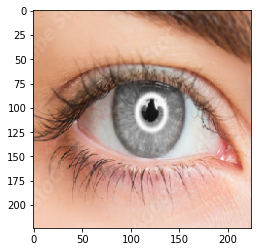

In [40]:
uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
    
  #buat ngecek multiclass
  # if classification_type == 'multiclass':
  if round(float(classes[0][0])) == 1:
    print('Normal')
  elif round(float(classes[0][1])) == 1:
    print('Retinoblastoma')
    
  # if round(float(classes[0])) == 1:
  #   print('Retinoblastoma')
  # elif round(float(classes[0])) == 0:
  #   print('normal')

light reflection = normal ✅

Saving eye39.jpg to eye39 (1).jpg
Retinoblastoma


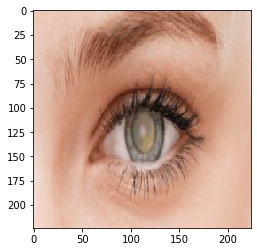

In [41]:
predict_images(model, 'multiclass')

white reflection = retinoblastoma ✅

Saving eye7.jpg to eye7.jpg
Retinoblastoma


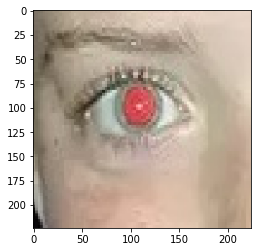

In [43]:
predict_images(model, 'multiclass')

red reflction = retinoblastoma ✅

Saving eye27.jpg to eye27.jpg
Retinoblastoma


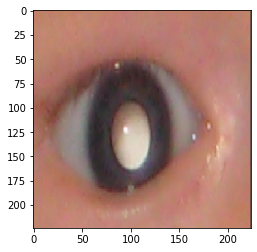

In [45]:
predict_images(model, 'multiclass')

another white reflection = retinoblastoma ✅

Saving eye38.jpg to eye38 (1).jpg
Normal


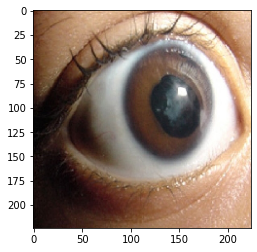

In [46]:
predict_images(model, 'multiclass')

light reflection = normal ✅

Saving eye9.jpg to eye9.jpg
Retinoblastoma


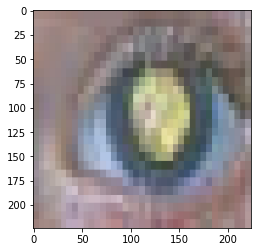

In [47]:
predict_images(model, 'multiclass')

yellow reflection = retinoblastoma ✅

Saving eye40.jpg to eye40.jpg
Normal


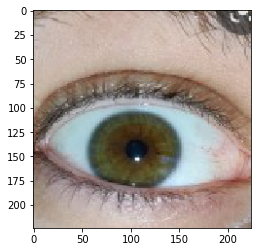

In [48]:
predict_images(model, 'multiclass')

no reflection = normal ✅

# Save Model

In [50]:
import pathlib

model.save("model_Basedvgg-3_multiclass.h5")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()

# tflite_model_file = pathlib.Path("/content/tflite")
# tflite_model_file.write_bytes(tflite_model)

# Save the model.
with open('model_VGGBased-3_multiclass.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp08cgn8s0/assets


INFO:tensorflow:Assets written to: /tmp/tmp08cgn8s0/assets
